download the source code from the query results of the YADAMP website (search:with 3D structure only filter)

URL : " view-source:http://yadamp.unisa.it/searchDatabase.aspx "

rename it: "list_of_sequences".aspx


In [2]:
#note to get the list of sequences an html backend was copied and now we scan through this html file for the sequences.
#read from the file and pre process the strings extracting the sequences
src = 'C:\\Users\\samue\\Downloads\\'
keep=[]
with open(src+'list_of_sequences.aspx') as f:
    for line in f:
        if(line.find('seq=')!= -1):
            temp = line.split("seq=")
            temp = temp[1].split("\"")
            keep.append(temp[0])

print("ten extracted sequences: ",keep[0:10]);
print("total numbers of extracted sequences: ",len(keep))
f.close()

# only write the sequences to a text file for later use.
with open(src+'yadamp_sequences.txt',"w") as f:
    for seq in keep:
        f.write(seq)
        f.write("\n")
f.close()

ten extracted sequences:  ['ACSAG', 'AMVGT', 'AMVSS', 'DDDDDD', 'FRWWHR', 'PGLGFY', 'RRWQWR', 'RRWWRF', 'CLAIGRR', 'FPWWWPF']
total numbers of extracted sequences:  1136


Next Search the YADAMP website for the matching PDB files for all the noted sequences and store them in a folder
(folder name used below: "PDBs")

In [3]:
import urllib.request
import time

count=0
with open(src+'yadamp_sequences.txt') as f:
    for sequence in f:
        sequence = sequence.strip("\n")+".pdb"
        time.sleep(0.001)
        webUrl = urllib.request.urlopen('http://yadamp.unisa.it/gmol/%s' % sequence)
        data = webUrl.readlines()

        #create a new directory in which all the PDB files should be stored
        with open(src+'PDBs\\'+'%s' % sequence, 'wb') as f_cor:
            for line in data:
                f_cor.write(line)
        f_cor.close()

        count += 1
        if count%5==0: print("count:%d finished %s" % (count, sequence))
f.close

count:5 finished FRWWHR.pdb


KeyboardInterrupt: 

The next step is to go through all the PDB files and extract the amino acids, phi and psi dihedral angles. (using BIOpython)

In [5]:
from Bio.PDB import PDBParser
import Bio.PDB
from Bio.PDB import PPBuilder
from Bio.Struct.Geometry import center_of_mass
from Bio.PDB import internal_coords
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

AA_list = np.zeros((0))
#open the folder where all of the PDBs are stored
for file in os.listdir(src+"PDBs"):

    directory = src+"PDBs\\%s" % file
    #print(counter,directory)
    p = PDBParser()
    s = p.get_structure("", directory) 
    

    #https://warwick.ac.uk/fac/sci/moac/people/students/peter_cock/python/ramachandran/calculate VERY USEFUL!!
    #get the phi and psi angles using biopython
    for chain in s :
        polypeptides = Bio.PDB.PPBuilder().build_peptides(chain)
        for poly_index, poly in enumerate(polypeptides) :
            
            print ("(part %i of %i)" % (poly_index+1, len(polypeptides)), "\tlength %i" % (len(poly))),
            print ("from %s%i" % (poly[0].resname, poly[0].id[1]) ,"to %s%i" % (poly[-1].resname, poly[-1].id[1]))
            
            phi_psi = poly.get_phi_psi_list()
            for res_index, residue in enumerate(poly) :
                res_name = "%s%i" % (residue.resname, residue.id[1])
                AA_list =np.append(AA_list,[res_name[:3], phi_psi[res_index][0],phi_psi[res_index][1]])

print(AA_list.size)
d = {"Amino Acids":AA_list[range(0,AA_list.size,3)],"phi":AA_list[range(1,AA_list.size,3)],"psi":AA_list[range(2,AA_list.size,3)]}
df = pd.DataFrame(d)
#save the dataframe so that this only needs to be done once
df.to_csv('dataframe_internal_coordinates.csv')


(part 1 of 1) 	length 5
from ALA1 to GLY5
(part 1 of 1) 	length 5
from ALA1 to THR5
(part 1 of 1) 	length 5
from ALA1 to SER5
(part 1 of 1) 	length 6
from ASP1 to ASP6
(part 1 of 1) 	length 6
from PHE1 to ARG6
81


Now that the structures are saved in a csv file, with their angles, we can start preparing the data for Neural Net input

In [175]:
import pandas as pd
import numpy as np
src= "C:\\Users\\samue\\Downloads\\research_project\\Databases\\dataframe_internal_coordinates.csv"
df = pd.read_csv(src)

The first step will be to scale the phi/psi angles to fit between 0 and 1

In [176]:
df.head(3)

,Unnamed: 0,Amino Acids,phi,psi
0,0,ALA,NaN,2.833464
1,1,ALA,-2.637405,2.960152
2,2,ALA,-1.349753,2.491088


In [177]:
coded_AA_list=[]
possible_AA= ['ala','arg','asn','asp','cys','glu','gln','gly','his','ile','leu','lys','met','phe','pro','ser','thr','trp','tyr','val']
for i in df['Amino Acids']:
    for acid in possible_AA:
        if i.lower() == acid:
            #print(acid,possible_AA.index(acid))    #to visualize the conversion uncomment this
            coded_AA_list.append((possible_AA.index(acid)+1)/20) #normalizing
            
               
df.insert(loc=df.columns.size, column='Coded_AA', value=coded_AA_list)

In [178]:
from sklearn import preprocessing
import math
#Scaling the angles appropriately
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaler.fit(np.reshape([-np.pi,np.pi],(-1,1))) #this makes sure to scale data using min -pi and max +pi
scaled_phi = scaler.transform(df['phi'].values.reshape(-1,1))
scaled_psi = scaler.transform(df['psi'].values.reshape(-1,1))

df.insert(loc=df.columns.size, column='scaled_phi', value=scaled_phi)
df.insert(loc=df.columns.size, column='scaled_psi', value=scaled_psi)

In [179]:
df.head(5)

,Unnamed: 0,Amino Acids,phi,psi,Coded_AA,scaled_phi,scaled_psi
0,0,ALA,NaN,2.833464,0.05,NaN,0.950960
1,1,ALA,-2.637405,2.960152,0.05,0.080244,0.971123
2,2,ALA,-1.349753,2.491088,0.05,0.285180,0.896469
3,3,ALA,-1.612154,-0.667668,0.05,0.243418,0.393737
4,4,GLY,2.514027,-2.779758,0.40,0.900120,0.057588


Next the longest AMP structure is found and the other AMP's are padded with 0's in order to match the length

In [180]:
#find max length to know how much to pad, sequences are currently delimited by 0's
counter=0
lengths=[]
for phi in scaled_phi:
    if(phi==scaled_phi[-1]):
        lengths.append(counter+2)
        counter=0
    if(math.isnan(phi)):
        lengths.append(counter+1)
        counter=0
    else:
        counter+=1
longest_amp = max(lengths)
longest_amp

45

In [181]:
#Here the propper length and order of the AMPS is stored and will come in handy later on
list_of_AA_lengths = pd.DataFrame([lengths[1:]])
list_of_AA_lengths = list_of_AA_lengths.transpose()
list_of_AA_lengths.columns = ["lengths"]
list_of_AA_lengths.to_csv("sorted_AA_endpoints.csv")

In [182]:
#Here we split up the AMPs in order to pad them individually to equal lengths
temp_df = list_of_AA_lengths
df_save=[]
for i in range(len(temp_df.values)):
    #print(df["Amino Acids"][:temp_df['lengths'][i]+1].values) #uncomment to get more information
    #print(temp_df['lengths'][i]+1)
    df_save.append(df[: temp_df['lengths'][i]])
    df = df[ temp_df['lengths'][i] :]
    

Then the padding is done such that all entries are the same length

In [183]:
for i in range(len(df_save)):
    if len(df_save[i]) < longest_amp:
        zero_append = pd.DataFrame(np.zeros( (longest_amp-len(df_save[i]),len(df_save[i].columns)) ), columns=df_save[i].columns)
        df_save[i] = df_save[i].append(zero_append)

43
40
10
10
16
20
20
20
20
33
17
19
18
20
37
37
36
5
30
30
30
30
30
30
24
12
8
32
38
30
13
39
9
9
14
29
43
30
42
42
15
12
15
15
15
15
17
18
15
9
9
9
9
31
9
9
17
18
9
9
5
5
31
15
30
40
41
8
8
8
8
8
8
8
40
40
44
45
15
41
26
43
43
40
43
40
40
40
40
40
40
40
40
40
40
40
10
40
20
40
44
17
38
44
44
43
39
16
17
17
13
11
41
15
9
9
30
23
19
31
31
30
34
34
36
34
36
19
7
21
19
19
29
16
29
34
38
38
44
16
30
6
10
42
9
38
37
36
15
11
11
37
44
43
44
43
44
44
11
10
39
34
25
15
43
13
42
18
9
15
37
13
40
40
40
16
36
16
15
18
18
36
9
9
11
11
14
11
11
11
15
10
15
15
18
16
18
39
18
18
40
20
15
18
11
12
14
15
15
14
14
14
14
11
8
18
13
13
22
23
22
23
23
23
8
14
16
13
16
10
13
13
16
14
17
17
13
19
19
31
17
15
13
13
13
13
16
14
14
14
13
13
17
15
25
13
15
15
16
13
18
14
18
18
18
13
13
13
17
17
13
14
17
13
13
13
13
13
13
13
16
17
12
13
13
13
13
13
13
13
13
13
14
13
13
13
16
16
13
13
14
18
13
13
13
15
13
13
13
13
13
13
13
13
17
13
13
14
13
17
17
13
13
29
13
13
13
19
13
13
13
13
30
18
12
13
13
12
12
12
12
13
13
7


In [187]:
df1 = pd.DataFrame()
for i in range(len(df_save)):
    df1 = df1.append(df_save[i])

In [189]:
print(len(df1)) #51120/55=1136 as expected

51120


Re-attach all AMPs into 1 dataframe and get rid of nan's

In [190]:
#need to set the remaining NAN's in the angles to zero
df1['scaled_phi'] = df1['scaled_phi'].fillna(0)
df1['scaled_psi'] = df1['scaled_psi'].fillna(0)
df1

,Unnamed: 0,Amino Acids,phi,psi,Coded_AA,scaled_phi,scaled_psi
0,0.0,ALA,NaN,2.833464,0.05,0.000000,0.950960
1,1.0,ALA,-2.637405,2.960152,0.05,0.080244,0.971123
2,2.0,ALA,-1.349753,2.491088,0.05,0.285180,0.896469
3,3.0,ALA,-1.612154,-0.667668,0.05,0.243418,0.393737
4,4.0,GLY,2.514027,-2.779758,0.40,0.900120,0.057588
...,...,...,...,...,...,...,...
5,0.0,0,0.000000,0.000000,0.00,0.000000,0.000000
6,0.0,0,0.000000,0.000000,0.00,0.000000,0.000000
7,0.0,0,0.000000,0.000000,0.00,0.000000,0.000000
8,0.0,0,0.000000,0.000000,0.00,0.000000,0.000000


Finally export the modifed CSV

In [193]:
df1.to_csv('prepped_data.csv')

Re-load the saved csv and continue preparing for network input

In [3]:
import pandas as pd
src= "C:\\Users\\samue\\Downloads\\research_project\\VAE\\prepped_data.csv"
df = pd.read_csv(src)
#this will be used when doing loss calculations in order to ignore the zeros.(by knowing the length of each AMP)
src= "C:\\Users\\samue\\Downloads\\research_project\\VAE\\sorted_AA_endpoints.csv"
endpts = pd.read_csv(src)
df.head(5)

,Unnamed: 0,Unnamed: 0.1,Amino Acids,phi,psi,Coded_AA,scaled_phi,scaled_psi
0,0,0.0,ALA,NaN,2.833464,0.05,0.000000,0.950960
1,1,1.0,ALA,-2.637405,2.960152,0.05,0.080244,0.971123
2,2,2.0,ALA,-1.349753,2.491088,0.05,0.285180,0.896469
3,3,3.0,ALA,-1.612154,-0.667668,0.05,0.243418,0.393737
4,4,4.0,GLY,2.514027,-2.779758,0.40,0.900120,0.057588


Create a torch tensor from the dataframe and customize the shape such that it is of the form: [#structures,1,Max_seq_len]   
then concatenate 3 of these together to obtain the shape [#structures,3,Max_seq_len]

In [4]:
import torch
import torch.utils.data
from torch import nn, optim

longest_amp=45
Amino_Acids = torch.tensor([df.iloc[:,[5]].values])
#dividing the total number of amino acids by the max found size of structures gives the total # of structures
num_structures = Amino_Acids.shape[1]//longest_amp 
Amino_Acids = torch.reshape(Amino_Acids, (num_structures,1,longest_amp))
phi = torch.tensor([df.iloc[:,[6]].values])
phi = torch.reshape(phi, (num_structures,1,longest_amp))
psi = torch.tensor([df.iloc[:,[7]].values])
psi = torch.reshape(psi, (num_structures,1,longest_amp))

#cat concatenates the tensors into the given dimension here the dim is the channel dim
LOAD_DATA = torch.cat((Amino_Acids,phi,psi),1)

#randomly shuffling first dimension of Torch Tensor soo re-allocating the 1142 AMPs with AA-seq and phi, psi angles
idx = torch.randperm(LOAD_DATA.size()[0])
shuffled = torch.zeros_like(LOAD_DATA)
for i in range(len(idx)):
    shuffled[i] = LOAD_DATA[idx[i]]
LOAD_DATA_shuff = shuffled

Seperate training and testing data into: 90% 10% respectively

In [5]:
#seperate training and testing data
VAL_PCT = 0.04
val_size = int(LOAD_DATA.size()[0]*VAL_PCT) #use the size of the first dim(the # of structures to split 10%/90%)

train_X =LOAD_DATA_shuff[:-val_size]
test_X = LOAD_DATA_shuff[-val_size:]

pre_train_X = train_X[:len(train_X)//1]
pre_test_X = test_X[:len(test_X)//1]


real_train_X = train_X[:len(train_X)//1]
real_test_X = test_X[:len(test_X)//1]

#real_train_X = train_X[len(train_X)//1:]
#real_test_X = test_X[len(test_X)//1:]

Identify and verify the input data and shape of the network

In [6]:
print("train shape: ",train_X.shape,"test shape: ",test_X.shape)
print("pre-train shape: ",pre_train_X.shape,"pre-test shape: ",pre_test_X.shape)
print("real-train shape: ",real_train_X.shape,"real-test shape: ",real_test_X.shape)

train shape:  torch.Size([1091, 3, 45]) test shape:  torch.Size([45, 3, 45])
pre-train shape:  torch.Size([1091, 3, 45]) pre-test shape:  torch.Size([45, 3, 45])
real-train shape:  torch.Size([1091, 3, 45]) real-test shape:  torch.Size([45, 3, 45])


In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

#----------------------------------------HYPER-PARAMS--------------------------------------------------------#
batch_size=32
k_size=[1,3,4] #kernel sizes
NAA=45 #this variable represents the max number of AminoAcids in one structure
epochs=200
cuda=False
seed=1

cuda = not cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
torch.manual_seed(seed)

#This function is necessary to allow variable kernel size input in the hyper-parameters
def conv_output_shape(num_conv_layers, NAA, k_size, padding=0, stride=1):
    #using a formula to calculate the shape output of CONV layers output [(W−K+2P)/S]+1
    #W is the input volume //K is the Kernel size //P is the padding //S is the stride
    c_out=NAA
    tot_layers= num_conv_layers
    while(num_conv_layers>0): 
        c_out =( (c_out-k_size[tot_layers-num_conv_layers]+(2*0)//1)+1 )
        num_conv_layers-=1
    return c_out
        
#----------------------------------------VAE--------------------------------------------------------#
#inspired by:https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb
class VAE_pre(nn.Module):
    def __init__(self, NAA,k_size):
        super(VAE_pre, self).__init__()
        self.encoder = nn.Sequential(
            #conv1d(in_shape,out_shape,conv_kernels)
            nn.Conv1d(3, 32, kernel_size=k_size[0]),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=k_size[1]),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=k_size[2]),
            nn.ReLU(),
        )
        
        
        c_out = conv_output_shape(3,NAA,k_size)
        #input to flattened linear layer is conv_out*#channels
        self.fc1 = nn.Linear(c_out*128, 64)
        self.fc2 = nn.Linear(c_out*128, 64)
        self.fc3 = nn.Linear(64, c_out*128) #this one is for decoding
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=k_size[2]),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=k_size[1]),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 3, kernel_size=k_size[0]),
            nn.Sigmoid()
        )
 
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = mu+logvar
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0),-1) #flattening
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = z.view(z.size(0),128,conv_output_shape(3,NAA,k_size)) #unflattening
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar
#----------------------------------------VAE-END--------------------------------------------------------#
model = VAE_pre(NAA, k_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#----------------------------------------LOSS/TRAIN/TEST--------------------------------------------------------#
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, batch_number):
    
    MSE_list=0
    BCE_list=0
     #"idx" holds the index for scrambling the data. traverse scrambled data and find lengths of AMPS
    for i in range(x.shape[0]):
        AMP_len = endpts['lengths'][ int(torch.IntTensor.item(idx[i+batch_number])) ]
        #separate the AA from the phi and psi angles and do BCE on AA and MSE on phi and psi
        BCE_cur= F.binary_cross_entropy(recon_x[i][0],x[i][0], reduction='sum')
        MSE_cur = F.mse_loss(recon_x[i][1:],x[i][1:], reduction='sum')
        if i==0: 
            MSE_list = MSE_cur
            AA_list = BCE_cur
        else: 
            MSE_list = MSE_list+MSE_cur
            BCE_list = BCE_list+BCE_cur
    MSE = MSE_list
    BCE = BCE_list
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (MSE+ BCE) + KLD #+ total_difference*0.01
  

def accuracy(recon_x, x):
    #recon_x[16,3,44], x[16,3,44]
    recon_x_AA = torch.round(recon_x[:,0]*20)
    x_AA = torch.round(x[:,0]*20)
    AA_acc, phi, psi=0,0,0
    for i in range(len(recon_x_AA)):
        AMP_len = endpts['lengths'][ int(torch.IntTensor.item(idx[i])) ]  #find the length of the true AMP
        narrow_x = torch.narrow(x_AA[i], dim=0, start=0, length=int(AMP_len) ) #narrow the batch and reconstructed output
        narrow_recon = torch.narrow(recon_x_AA[i], dim=0, start=0, length=int(AMP_len))
        difference = torch.sub(narrow_x, narrow_recon)
        for j in difference: 
            if j==0: AA_acc+=(1/AMP_len) #if there is a match add one to that accuracy

        #accuracy of phi and psi first normalized by the number of angles in 1 AMP(45) then normalized for AMPs in 1 batch(32)
        narrow_x_phi = torch.narrow(x[:,1][i], dim=0, start=0, length=int(AMP_len))
        narrow_x_psi = torch.narrow(x[:,2][i], dim=0, start=0, length=int(AMP_len))
        narrow_recon_x_phi = torch.narrow(recon_x[:,1][i], dim=0, start=0, length=int(AMP_len))
        narrow_recon_x_psi = torch.narrow(recon_x[:,2][i], dim=0, start=0, length=int(AMP_len))
        phi += torch.sum( abs(torch.sub(narrow_x_phi, narrow_recon_x_phi)) ) / AMP_len
        psi += torch.sum( abs(torch.sub(narrow_x_psi, narrow_recon_x_psi)) ) / AMP_len
        
    return AA_acc, phi, psi

 
def train(epoch):
    model.train()
    train_loss = 0
    acc_train, phi, psi = 0,0,0
    for i in tqdm(range(0, len(pre_train_X), batch_size)):
        batch_X = pre_train_X[i:i+batch_size] #grab the batch
        batch_X = batch_X.float()
        batch_X = batch_X.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch_X)
        
        all_acc = accuracy(recon_batch, batch_X)
        acc_train += all_acc[0]/(batch_size)
        phi += all_acc[1]/(batch_size)
        psi += all_acc[2]/(batch_size)
        loss = loss_function(recon_batch, batch_X, mu, logvar, i)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    train_loss_list.append(train_loss / len(pre_train_X) )
    accuracy_train_list.append(acc_train / np.ceil(len(pre_train_X)/batch_size))
    phi_train_list.append(phi / np.ceil(len(real_train_X)/batch_size))
    psi_train_list.append(psi / np.ceil(len(real_train_X)/batch_size))
    print('====> Epoch: {} Average loss: {:.4f}, AA-accuracy:{:.3f}%'.format(
          epoch, train_loss /len(pre_train_X), (acc_train*100)/(len(pre_train_X)/batch_size) ))
    print('====> phi-error:{:.3f}/1, psi-error:{:.3f}/1'.format(
        (phi/(len(pre_train_X)/batch_size)),(psi/(len(pre_train_X)/batch_size))) )

def test(epoch):
    model.eval()
    test_loss = 0
    acc_test, phi_test, psi_test = 0,0,0
    with torch.no_grad():
        for i in tqdm(range(0, len(pre_test_X) )): #no longer need to do batches
            batch_X = pre_test_X[i].view(1,3,NAA) #grab the batch
            batch_X = batch_X.float()
            batch_X = batch_X.to(device)
            recon_batch, mu, logvar = model(batch_X)
            
            all_acc = accuracy(recon_batch, batch_X)
            acc_test += all_acc[0]
            phi_test += all_acc[1]
            psi_test += all_acc[2]
            test_loss += loss_function(recon_batch, batch_X, mu, logvar, i).item()
            
    acc_test /= len(pre_test_X) 
    phi_test /= len(pre_test_X)
    psi_test /= len(pre_test_X)
    test_loss /= len(pre_test_X)
    test_loss_list.append(test_loss)
    acc_test_list.append(acc_test)
    phi_test_list.append(phi_test)
    psi_test_list.append(psi_test)
    print('====> Test set loss: {:.4f}, AA-accuracy:{:.3f}%'.format(test_loss, acc_test*100))
    print('====> phi-error:{:.3f}/1, psi-error:{:.3f}/1'.format(phi_test, psi_test))
#----------------------------------------(LOSS/TRAIN/TEST)-END--------------------------------------------------------#
if __name__ == "__main__":
    train_loss_list=[]
    test_loss_list=[]
    accuracy_train_list = []
    acc_test_list = []
    phi_train_list = []
    phi_test_list = []
    psi_train_list = []
    psi_test_list = []
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
    fig, axs = plt.subplots(2, 2, figsize=(9,7), dpi=90)
    axs[0,0].plot(train_loss_list)
    axs[0,0].plot(test_loss_list)
    axs[0,0].set_title("train loss (B) VS. test loss (Y)")
    axs[0,1].plot(accuracy_train_list)
    axs[0,1].plot(acc_test_list)
    axs[0,1].set_title("train AA acc (B) VS. test AA acc (Y)")
    axs[1,0].plot(phi_train_list)
    axs[1,0].plot(phi_test_list)
    axs[1,0].set_title("train phi err (B) VS. test phi err (Y)")
    axs[1,1].plot(psi_train_list)
    axs[1,1].plot(psi_test_list)
    axs[1,1].set_title("train psi err (B) VS. test phi err (Y)")

  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 45.7693, AA-accuracy:4.081%
====> phi-error:0.357/1, psi-error:0.215/1
====> Test set loss: 17.7170, AA-accuracy:4.356%
====> phi-error:0.336/1, psi-error:0.267/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 2 Average loss: 34.2531, AA-accuracy:4.639%
====> phi-error:0.238/1, psi-error:0.199/1
====> Test set loss: 9.5340, AA-accuracy:6.311%
====> phi-error:0.196/1, psi-error:0.199/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 3 Average loss: 24.6436, AA-accuracy:7.102%
====> phi-error:0.172/1, psi-error:0.169/1
====> Test set loss: 6.0472, AA-accuracy:11.200%
====> phi-error:0.146/1, psi-error:0.171/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 4 Average loss: 21.3846, AA-accuracy:10.293%
====> phi-error:0.142/1, psi-error:0.159/1
====> Test set loss: 4.9453, AA-accuracy:20.711%
====> phi-error:0.121/1, psi-error:0.159/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 5 Average loss: 19.7496, AA-accuracy:13.035%
====> phi-error:0.125/1, psi-error:0.154/1
====> Test set loss: 4.2394, AA-accuracy:22.933%
====> phi-error:0.118/1, psi-error:0.152/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 6 Average loss: 18.7826, AA-accuracy:14.939%
====> phi-error:0.116/1, psi-error:0.152/1
====> Test set loss: 3.7488, AA-accuracy:26.044%
====> phi-error:0.109/1, psi-error:0.145/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 7 Average loss: 18.0752, AA-accuracy:16.415%
====> phi-error:0.112/1, psi-error:0.150/1
====> Test set loss: 3.4131, AA-accuracy:28.267%
====> phi-error:0.105/1, psi-error:0.140/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 8 Average loss: 17.5124, AA-accuracy:17.376%
====> phi-error:0.109/1, psi-error:0.149/1
====> Test set loss: 3.1629, AA-accuracy:28.800%
====> phi-error:0.104/1, psi-error:0.136/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 9 Average loss: 17.0889, AA-accuracy:17.978%
====> phi-error:0.106/1, psi-error:0.148/1
====> Test set loss: 2.9750, AA-accuracy:29.867%
====> phi-error:0.102/1, psi-error:0.136/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 10 Average loss: 16.7715, AA-accuracy:18.819%
====> phi-error:0.103/1, psi-error:0.148/1
====> Test set loss: 2.8597, AA-accuracy:31.111%
====> phi-error:0.098/1, psi-error:0.135/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 11 Average loss: 16.4068, AA-accuracy:19.515%
====> phi-error:0.100/1, psi-error:0.146/1
====> Test set loss: 2.8381, AA-accuracy:31.556%
====> phi-error:0.096/1, psi-error:0.134/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 12 Average loss: 16.1480, AA-accuracy:19.826%
====> phi-error:0.097/1, psi-error:0.145/1
====> Test set loss: 2.7199, AA-accuracy:32.178%
====> phi-error:0.093/1, psi-error:0.132/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 13 Average loss: 15.9549, AA-accuracy:20.052%
====> phi-error:0.095/1, psi-error:0.145/1
====> Test set loss: 2.5384, AA-accuracy:31.289%
====> phi-error:0.096/1, psi-error:0.132/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 14 Average loss: 15.5170, AA-accuracy:20.937%
====> phi-error:0.092/1, psi-error:0.142/1
====> Test set loss: 2.4685, AA-accuracy:31.556%
====> phi-error:0.094/1, psi-error:0.132/1


 96%|█████████▌| 43/45 [00:00<00:00, 219.63it/s]

====> Epoch: 15 Average loss: 15.1920, AA-accuracy:22.544%
====> phi-error:0.090/1, psi-error:0.141/1


  3%|▎         | 1/35 [00:00<00:03,  9.62it/s]

====> Test set loss: 2.4199, AA-accuracy:34.044%
====> phi-error:0.089/1, psi-error:0.127/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 16 Average loss: 14.8726, AA-accuracy:24.250%
====> phi-error:0.088/1, psi-error:0.140/1
====> Test set loss: 2.4497, AA-accuracy:35.022%
====> phi-error:0.087/1, psi-error:0.126/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 17 Average loss: 14.6150, AA-accuracy:26.538%
====> phi-error:0.087/1, psi-error:0.139/1
====> Test set loss: 2.4209, AA-accuracy:37.333%
====> phi-error:0.086/1, psi-error:0.126/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 18 Average loss: 14.4023, AA-accuracy:28.808%
====> phi-error:0.086/1, psi-error:0.138/1
====> Test set loss: 2.2571, AA-accuracy:39.022%
====> phi-error:0.088/1, psi-error:0.125/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 19 Average loss: 14.3672, AA-accuracy:30.020%
====> phi-error:0.086/1, psi-error:0.138/1
====> Test set loss: 2.2305, AA-accuracy:37.422%
====> phi-error:0.091/1, psi-error:0.125/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 20 Average loss: 14.1675, AA-accuracy:31.819%
====> phi-error:0.085/1, psi-error:0.136/1
====> Test set loss: 2.4448, AA-accuracy:40.800%
====> phi-error:0.086/1, psi-error:0.125/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 21 Average loss: 14.0384, AA-accuracy:33.671%
====> phi-error:0.084/1, psi-error:0.135/1
====> Test set loss: 2.1505, AA-accuracy:42.933%
====> phi-error:0.084/1, psi-error:0.121/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 22 Average loss: 13.8570, AA-accuracy:34.957%
====> phi-error:0.083/1, psi-error:0.133/1
====> Test set loss: 2.1291, AA-accuracy:41.244%
====> phi-error:0.090/1, psi-error:0.126/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 23 Average loss: 13.7599, AA-accuracy:35.398%
====> phi-error:0.082/1, psi-error:0.132/1
====> Test set loss: 2.0462, AA-accuracy:44.711%
====> phi-error:0.084/1, psi-error:0.120/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 24 Average loss: 13.5819, AA-accuracy:37.164%
====> phi-error:0.081/1, psi-error:0.130/1
====> Test set loss: 2.0184, AA-accuracy:47.378%
====> phi-error:0.082/1, psi-error:0.115/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 25 Average loss: 13.4666, AA-accuracy:38.724%
====> phi-error:0.080/1, psi-error:0.128/1
====> Test set loss: 1.9820, AA-accuracy:48.622%
====> phi-error:0.081/1, psi-error:0.114/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 26 Average loss: 13.3701, AA-accuracy:39.824%
====> phi-error:0.080/1, psi-error:0.126/1
====> Test set loss: 1.9341, AA-accuracy:50.044%
====> phi-error:0.081/1, psi-error:0.112/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 27 Average loss: 13.2859, AA-accuracy:40.726%
====> phi-error:0.079/1, psi-error:0.124/1
====> Test set loss: 1.8917, AA-accuracy:49.956%
====> phi-error:0.081/1, psi-error:0.111/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 28 Average loss: 13.2233, AA-accuracy:41.424%
====> phi-error:0.079/1, psi-error:0.123/1
====> Test set loss: 1.8606, AA-accuracy:49.067%
====> phi-error:0.082/1, psi-error:0.111/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 29 Average loss: 13.1778, AA-accuracy:41.866%
====> phi-error:0.078/1, psi-error:0.122/1
====> Test set loss: 1.8314, AA-accuracy:48.000%
====> phi-error:0.082/1, psi-error:0.110/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 30 Average loss: 13.1661, AA-accuracy:41.768%
====> phi-error:0.078/1, psi-error:0.121/1
====> Test set loss: 1.8319, AA-accuracy:50.756%
====> phi-error:0.078/1, psi-error:0.107/1


 49%|████▉     | 22/45 [00:00<00:00, 213.66it/s]

====> Epoch: 31 Average loss: 13.1413, AA-accuracy:40.475%
====> phi-error:0.078/1, psi-error:0.120/1


  6%|▌         | 2/35 [00:00<00:02, 13.85it/s]

====> Test set loss: 1.8427, AA-accuracy:44.711%
====> phi-error:0.080/1, psi-error:0.109/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 32 Average loss: 13.0638, AA-accuracy:41.861%
====> phi-error:0.077/1, psi-error:0.119/1
====> Test set loss: 1.7657, AA-accuracy:52.178%
====> phi-error:0.080/1, psi-error:0.107/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 33 Average loss: 12.9855, AA-accuracy:43.709%
====> phi-error:0.076/1, psi-error:0.118/1
====> Test set loss: 1.7407, AA-accuracy:53.511%
====> phi-error:0.078/1, psi-error:0.104/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 34 Average loss: 12.9283, AA-accuracy:44.790%
====> phi-error:0.076/1, psi-error:0.116/1
====> Test set loss: 1.7214, AA-accuracy:51.911%
====> phi-error:0.079/1, psi-error:0.104/1


 49%|████▉     | 22/45 [00:00<00:00, 215.75it/s]

====> Epoch: 35 Average loss: 12.8739, AA-accuracy:44.814%
====> phi-error:0.075/1, psi-error:0.115/1


  3%|▎         | 1/35 [00:00<00:03,  9.09it/s]

====> Test set loss: 1.6933, AA-accuracy:53.333%
====> phi-error:0.080/1, psi-error:0.104/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 36 Average loss: 12.8252, AA-accuracy:46.169%
====> phi-error:0.075/1, psi-error:0.114/1
====> Test set loss: 1.6713, AA-accuracy:52.800%
====> phi-error:0.079/1, psi-error:0.103/1


  9%|▉         | 4/45 [00:00<00:01, 38.47it/s]

====> Epoch: 37 Average loss: 12.7927, AA-accuracy:46.406%
====> phi-error:0.075/1, psi-error:0.113/1


  6%|▌         | 2/35 [00:00<00:03, 10.59it/s]

====> Test set loss: 1.6532, AA-accuracy:52.356%
====> phi-error:0.080/1, psi-error:0.103/1


 18%|█▊        | 8/45 [00:00<00:00, 77.69it/s]

====> Epoch: 38 Average loss: 12.7604, AA-accuracy:46.746%
====> phi-error:0.074/1, psi-error:0.113/1


  6%|▌         | 2/35 [00:00<00:02, 11.56it/s]

====> Test set loss: 1.6275, AA-accuracy:53.422%
====> phi-error:0.079/1, psi-error:0.102/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 39 Average loss: 12.7276, AA-accuracy:47.083%
====> phi-error:0.074/1, psi-error:0.112/1
====> Test set loss: 1.6021, AA-accuracy:56.444%
====> phi-error:0.077/1, psi-error:0.100/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 40 Average loss: 12.6991, AA-accuracy:46.848%
====> phi-error:0.074/1, psi-error:0.111/1
====> Test set loss: 1.5969, AA-accuracy:53.867%
====> phi-error:0.076/1, psi-error:0.099/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 41 Average loss: 12.7206, AA-accuracy:45.529%
====> phi-error:0.074/1, psi-error:0.111/1
====> Test set loss: 1.6832, AA-accuracy:43.911%
====> phi-error:0.077/1, psi-error:0.103/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 42 Average loss: 12.8141, AA-accuracy:45.327%
====> phi-error:0.075/1, psi-error:0.111/1
====> Test set loss: 1.6416, AA-accuracy:50.044%
====> phi-error:0.085/1, psi-error:0.108/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 43 Average loss: 12.6810, AA-accuracy:44.713%
====> phi-error:0.073/1, psi-error:0.110/1
====> Test set loss: 1.5474, AA-accuracy:54.844%
====> phi-error:0.076/1, psi-error:0.100/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 44 Average loss: 12.6026, AA-accuracy:44.825%
====> phi-error:0.073/1, psi-error:0.109/1
====> Test set loss: 1.5475, AA-accuracy:54.844%
====> phi-error:0.075/1, psi-error:0.098/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 45 Average loss: 12.5907, AA-accuracy:44.663%
====> phi-error:0.073/1, psi-error:0.108/1
====> Test set loss: 1.5297, AA-accuracy:50.578%
====> phi-error:0.075/1, psi-error:0.099/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 46 Average loss: 12.6241, AA-accuracy:42.433%
====> phi-error:0.073/1, psi-error:0.108/1
====> Test set loss: 1.5034, AA-accuracy:49.511%
====> phi-error:0.077/1, psi-error:0.099/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 47 Average loss: 12.5822, AA-accuracy:41.952%
====> phi-error:0.073/1, psi-error:0.108/1
====> Test set loss: 1.4799, AA-accuracy:53.422%
====> phi-error:0.076/1, psi-error:0.095/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 48 Average loss: 12.4886, AA-accuracy:49.028%
====> phi-error:0.072/1, psi-error:0.105/1
====> Test set loss: 1.4757, AA-accuracy:56.444%
====> phi-error:0.074/1, psi-error:0.093/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 49 Average loss: 12.4481, AA-accuracy:50.015%
====> phi-error:0.072/1, psi-error:0.105/1
====> Test set loss: 1.4543, AA-accuracy:56.089%
====> phi-error:0.074/1, psi-error:0.093/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 50 Average loss: 12.4266, AA-accuracy:49.213%
====> phi-error:0.071/1, psi-error:0.104/1
====> Test set loss: 1.4320, AA-accuracy:57.600%
====> phi-error:0.075/1, psi-error:0.093/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 51 Average loss: 12.3962, AA-accuracy:50.433%
====> phi-error:0.071/1, psi-error:0.103/1
====> Test set loss: 1.4166, AA-accuracy:57.867%
====> phi-error:0.075/1, psi-error:0.093/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 52 Average loss: 12.3719, AA-accuracy:51.126%
====> phi-error:0.071/1, psi-error:0.103/1
====> Test set loss: 1.4024, AA-accuracy:57.956%
====> phi-error:0.075/1, psi-error:0.092/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 53 Average loss: 12.3482, AA-accuracy:51.671%
====> phi-error:0.071/1, psi-error:0.102/1
====> Test set loss: 1.3918, AA-accuracy:56.889%
====> phi-error:0.076/1, psi-error:0.093/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 54 Average loss: 12.3283, AA-accuracy:51.946%
====> phi-error:0.070/1, psi-error:0.101/1
====> Test set loss: 1.3821, AA-accuracy:56.533%
====> phi-error:0.076/1, psi-error:0.093/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 55 Average loss: 12.3108, AA-accuracy:52.234%
====> phi-error:0.070/1, psi-error:0.101/1
====> Test set loss: 1.3666, AA-accuracy:56.533%
====> phi-error:0.076/1, psi-error:0.092/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 56 Average loss: 12.2997, AA-accuracy:51.868%
====> phi-error:0.070/1, psi-error:0.100/1
====> Test set loss: 1.3564, AA-accuracy:55.911%
====> phi-error:0.076/1, psi-error:0.092/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 57 Average loss: 12.3067, AA-accuracy:50.992%
====> phi-error:0.070/1, psi-error:0.100/1
====> Test set loss: 1.3901, AA-accuracy:49.778%
====> phi-error:0.082/1, psi-error:0.095/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 58 Average loss: 12.3861, AA-accuracy:47.449%
====> phi-error:0.071/1, psi-error:0.101/1
====> Test set loss: 1.3662, AA-accuracy:56.800%
====> phi-error:0.072/1, psi-error:0.089/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 59 Average loss: 12.4103, AA-accuracy:49.630%
====> phi-error:0.071/1, psi-error:0.099/1
====> Test set loss: 1.3447, AA-accuracy:53.511%
====> phi-error:0.073/1, psi-error:0.088/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 60 Average loss: 12.2705, AA-accuracy:51.205%
====> phi-error:0.069/1, psi-error:0.098/1
====> Test set loss: 1.3097, AA-accuracy:58.844%
====> phi-error:0.072/1, psi-error:0.086/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 61 Average loss: 12.2211, AA-accuracy:54.233%
====> phi-error:0.069/1, psi-error:0.097/1
====> Test set loss: 1.2985, AA-accuracy:57.067%
====> phi-error:0.072/1, psi-error:0.086/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 62 Average loss: 12.1956, AA-accuracy:54.162%
====> phi-error:0.069/1, psi-error:0.097/1
====> Test set loss: 1.2771, AA-accuracy:58.400%
====> phi-error:0.072/1, psi-error:0.085/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 63 Average loss: 12.1725, AA-accuracy:55.189%
====> phi-error:0.069/1, psi-error:0.096/1
====> Test set loss: 1.2637, AA-accuracy:59.556%
====> phi-error:0.072/1, psi-error:0.084/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 64 Average loss: 12.1524, AA-accuracy:55.329%
====> phi-error:0.068/1, psi-error:0.095/1
====> Test set loss: 1.2519, AA-accuracy:58.311%
====> phi-error:0.071/1, psi-error:0.084/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 65 Average loss: 12.1327, AA-accuracy:55.902%
====> phi-error:0.068/1, psi-error:0.094/1
====> Test set loss: 1.2358, AA-accuracy:59.022%
====> phi-error:0.071/1, psi-error:0.083/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 66 Average loss: 12.1123, AA-accuracy:56.613%
====> phi-error:0.068/1, psi-error:0.094/1
====> Test set loss: 1.2198, AA-accuracy:60.267%
====> phi-error:0.071/1, psi-error:0.082/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 67 Average loss: 12.0933, AA-accuracy:57.025%
====> phi-error:0.068/1, psi-error:0.093/1
====> Test set loss: 1.2065, AA-accuracy:60.000%
====> phi-error:0.070/1, psi-error:0.081/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 68 Average loss: 12.0747, AA-accuracy:57.412%
====> phi-error:0.068/1, psi-error:0.092/1
====> Test set loss: 1.1913, AA-accuracy:60.089%
====> phi-error:0.071/1, psi-error:0.080/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 69 Average loss: 12.0563, AA-accuracy:57.697%
====> phi-error:0.067/1, psi-error:0.091/1
====> Test set loss: 1.1780, AA-accuracy:59.289%
====> phi-error:0.071/1, psi-error:0.080/1


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 70 Average loss: 12.0389, AA-accuracy:57.561%
====> phi-error:0.067/1, psi-error:0.091/1
====> Test set loss: 1.1663, AA-accuracy:58.311%
====> phi-error:0.070/1, psi-error:0.079/1


  6%|▌         | 2/35 [00:00<00:02, 14.19it/s]

In [ ]:
torch.save(model.state_dict(), "C:\\Users\\samue\\Downloads\\research_project\\VAE\\models\\model.pth")

In [21]:
with torch.no_grad():
    sn = 5
    sample = pre_train_X[sn].float().view(1,3,NAA)
    sample, mu, logvar = model.encode(sample)
    sample = model.decode(sample).cpu()
    print(sample.shape)

df_out = pd.DataFrame({"AA":pre_train_X[sn][0],"phi":pre_train_X[sn][1],"psi":pre_train_X[sn][2],"decoded_AA":sample[0][0],"decoded_phi":sample[0][1],"decoded_psi":sample[0][2]})

torch.Size([1, 3, 45])


<AxesSubplot:>

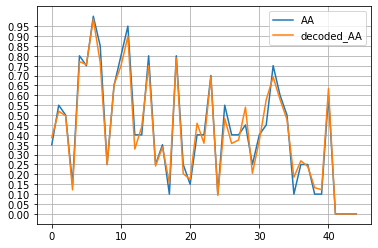

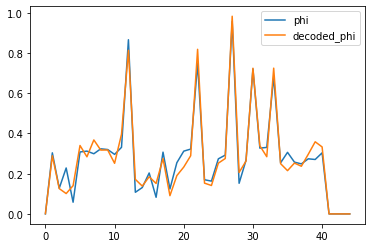

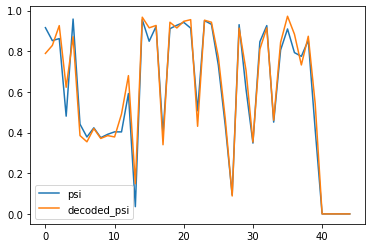

In [22]:
df_out.plot(y=(['AA','decoded_AA']),yticks=[i/20 for i in range(20)], grid=True)
df_out.plot(y=(['phi','decoded_phi']))
df_out.plot(y=(['psi','decoded_psi']))

Below is the complete implementation of the Convolutional Variational Auto-Encoder

In [33]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

#----------------------------------------HYPER-PARAMS--------------------------------------------------------#
batch_size=32
k_size=3 #kernel size
NAA=45 #this variable represents the max number of AminoAcids in one structure
epochs=3
cuda=False
seed=1

cuda = not cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
torch.manual_seed(seed)

#This function is necessary to allow variable kernel size input in the hyper-parameters
def conv_output_shape(num_conv_layers, NAA, k_size, padding=0, stride=1):
    #using a formula to calculate the shape output of CONV layers output [(W−K+2P)/S]+1
    #W is the input volume //K is the Kernel size //P is the padding //S is the stride
    c_out=NAA
    while(num_conv_layers>0): 
        c_out =( (c_out-k_size+(2*0)//1)+1 )
        num_conv_layers-=1
    return c_out
        
#----------------------------------------VAE--------------------------------------------------------#
#inspired by:https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb
class VAE(nn.Module):
    def __init__(self, NAA,k_size):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            #conv1d(in_shape,out_shape,conv_kernels)
            nn.Conv1d(3, 32, kernel_size=k_size),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=k_size),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=k_size),
            nn.ReLU()
        )
        
        c_out = conv_output_shape(3,NAA,k_size)
        #input to flattened linear layer is conv_out*#channels
        self.fc1 = nn.Linear(c_out*128, 64)
        self.fc2 = nn.Linear(c_out*128, 64)
        self.fc3 = nn.Linear(64, c_out*128) #this one is for decoding
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=k_size),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=k_size),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 3, kernel_size=k_size),
            nn.Sigmoid()
        )
 
        
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        # return torch.normal(mu, std)
        eps = torch.randn_like(mu)*0.05
        #print("EPS:",eps,"\n MU: ",mu,"\n LOGVAR: ",logvar)
        z = mu + std * eps
        return z
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0),-1) #flattening
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = z.view(z.size(0),128,conv_output_shape(3,NAA,k_size)) #unflattening
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar
#----------------------------------------VAE-END--------------------------------------------------------# 
model = VAE(NAA, k_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#----------------------------------------LOSS/TRAIN/TEST--------------------------------------------------------#
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, batch_number):
    
    MSE_list=0
    BCE_list=0
     #"idx" holds the index for scrambling the data. enpts[idx[i+(16*epoch-1)]] will traverse scrambled data and find lengths of AMPS
    for i in range(x.shape[0]):
        AMP_len = endpts['lengths'][ int(torch.IntTensor.item(idx[i+batch_number])) ]
        #separate the AA from the phi and psi angles and do BCE on AA and MSE on phi and psi
        #print(AMP_len,"\n", recon_x[i][0],"\n", x[i][0])
        BCE_cur= F.binary_cross_entropy(recon_x[i][0],x[i][0], reduction='sum')
        MSE_cur = F.mse_loss(recon_x[i][1:],x[i][1:], reduction='sum')
        if i==0: 
            MSE_list = MSE_cur
            AA_list = BCE_cur
        else: 
            MSE_list = MSE_list+MSE_cur
            BCE_list = BCE_list+BCE_cur
    
    MSE = MSE_list
    BCE = BCE_list
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE +MSE+ KLD#*KL_ANL #+ total_difference


def accuracy(recon_x, x):
    #recon_x[16,3,44], x[16,3,44]
    recon_x_AA = torch.round(recon_x[:,0]*20)
    x_AA = torch.round(x[:,0]*20)
    AA_acc, phi, psi=0,0,0

    for i in range(len(recon_x_AA)):
        AMP_len = endpts['lengths'][ int(torch.IntTensor.item(idx[i])) ]  #find the length of the true AMP
        narrow_x = torch.narrow(x_AA[i], dim=0, start=0, length=int(AMP_len) ) #narrow the batch and reconstructed output
        narrow_recon = torch.narrow(recon_x_AA[i], dim=0, start=0, length=int(AMP_len))
        difference = torch.sub(narrow_x, narrow_recon)
        for j in difference: 
            if j==0: AA_acc+=(1/AMP_len) #if there is a match add one to that accuracy
                
        #accuracy of phi and psi first normalized by the number of angles in 1 AMP(45) then normalized for AMPs in 1 batch(32)
        narrow_x_phi = torch.narrow(x[:,1][i], dim=0, start=0, length=int(AMP_len))
        narrow_x_psi = torch.narrow(x[:,2][i], dim=0, start=0, length=int(AMP_len))
        narrow_recon_x_phi = torch.narrow(recon_x[:,1][i], dim=0, start=0, length=int(AMP_len))
        narrow_recon_x_psi = torch.narrow(recon_x[:,2][i], dim=0, start=0, length=int(AMP_len))
        phi += torch.sum( abs(torch.sub(narrow_x_phi, narrow_recon_x_phi)) ) / AMP_len
        psi += torch.sum( abs(torch.sub(narrow_x_psi, narrow_recon_x_psi)) ) / AMP_len
       
    return AA_acc, phi, psi


def train(epoch):
    model.train()
    train_loss = 0
    acc, phi, psi=0,0,0
    for i in tqdm(range(0, len(real_train_X), batch_size)):
        batch_X = real_train_X[i:i+batch_size] #grab the batch
        batch_X = batch_X.float()
        batch_X = batch_X.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch_X)
        
        loss = loss_function(recon_batch, batch_X, mu, logvar, i)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        all_acc = accuracy(recon_batch, batch_X)
        acc += all_acc[0]/(batch_size)
        phi += all_acc[1]/(batch_size)
        psi += all_acc[2]/(batch_size)
    train_loss_list.append(train_loss/len(real_train_X))
    accuracy_train_list.append( acc/np.ceil(len(real_train_X)/batch_size) )
    phi_train_list.append(phi / np.ceil(len(real_train_X)/batch_size))
    psi_train_list.append(psi / np.ceil(len(real_train_X)/batch_size))
    print('====> Epoch: {} Average loss: {:.3f}, AA-accuracy:{:.3f}%'.format(
          epoch, train_loss /len(real_train_X), (acc*100)/(len(real_train_X)/batch_size) ))
    print('====> phi-error:{:.3f}/1, psi-error:{:.3f}/1'.format(
        (phi/(len(real_train_X)/batch_size)),(psi/(len(real_train_X)/batch_size))) )

def test(epoch):
    model.eval()
    test_loss = 0
    acc_test, phi_test, psi_test = 0,0,0
    with torch.no_grad():
        for i in tqdm(range(0, len(real_test_X) )): #no longer need to do batches
            batch_X = real_test_X[i].view(1,3,NAA) #sending one at a time
            batch_X = batch_X.float()
            batch_X = batch_X.to(device)
            recon_batch, mu, logvar = model(batch_X)
            all_acc = accuracy(recon_batch, batch_X)
            acc_test += all_acc[0]
            phi_test += all_acc[1]
            psi_test += all_acc[2]
            test_loss += loss_function(recon_batch, batch_X, mu, logvar, i).item()
            
    acc_test /= len(real_test_X)
    phi_test /= len(real_test_X)
    psi_test /= len(real_test_X)
    test_loss /= len(real_test_X)
    test_loss_list.append(test_loss)
    accuracy_test_list.append(acc_test)
    phi_test_list.append(phi_test)
    psi_test_list.append(psi_test)
    print('====> Test set loss: {:.3f}, AA-accuracy:{:.3f}%'.format(test_loss, acc_test*100))
    print('====> phi-error:{:.3f}/1, psi-error:{:.3f}/1'.format(phi_test, psi_test))
#----------------------------------------(LOSS/TRAIN/TEST)-END--------------------------------------------------------#
if __name__ == "__main__":
    train_loss_list=[]
    test_loss_list=[]
    accuracy_train_list = []
    accuracy_test_list = []
    phi_train_list = []
    phi_test_list = []
    psi_train_list = []
    psi_test_list = []

In [190]:
# Model class must be defined somewhere
model.load_state_dict(torch.load("C:\\Users\\samue\\Downloads\\research_project\\VAE\\models\\model.pth"))

<All keys matched successfully>

In [199]:
for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
fig, axs = plt.subplots(2, 2, figsize=(9,7), dpi=90)
axs[0,0].plot(train_loss_list)
axs[0,0].plot(test_loss_list)
axs[0,0].set_title("train loss (B) VS. test loss (Y)")
axs[0,1].plot(accuracy_train_list)
axs[0,1].plot(accuracy_test_list)
axs[0,1].set_title("train AA acc (B) VS. test AA acc (Y)")
axs[1,0].plot(phi_train_list)
axs[1,0].plot(phi_test_list)
axs[1,0].set_title("train phi err (B) VS. test phi err (Y)")
axs[1,1].plot(psi_train_list)
axs[1,1].plot(psi_test_list)
axs[1,1].set_title("train psi err (B) VS. test phi err (Y)")


  0%|          | 0/35 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 27.223, AA-accuracy:11.447%
====> phi-error:0.120/1, psi-error:0.176/1
====> Test set loss: 3.372, AA-accuracy:19.352%
====> phi-error:0.088/1, psi-error:0.150/1


 83%|████████▎ | 29/35 [00:01<00:00, 14.51it/s]


KeyboardInterrupt: 

In [38]:
torch.save(model.state_dict(), "C:\\Users\\samue\\Downloads\\research_project\\VAE\\models\\model.pth")

## This section is extra and serves to show some results of the network

In [76]:
with torch.no_grad():
    sn=7
#     sample = torch.randn(1, 16).to(device) #this is the current shape of the lattent space for batches of 1
    sample = real_test_X[sn].float().view(1,3,NAA)
    sample, mu, logvar = model.encode(sample)
    latent_size = sample.shape
    sample = model.decode(sample).cpu()
    
df_out = pd.DataFrame({"AA":real_test_X[sn][0],"phi":real_test_X[sn][1],"psi":real_test_X[sn][2],"decoded_AA":sample[0][0],"decoded_phi":sample[0][1],"decoded_psi":sample[0][2]})

<AxesSubplot:>

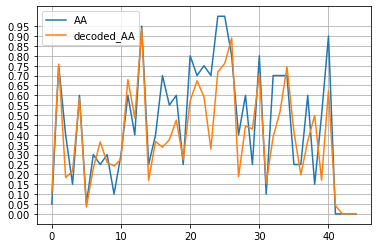

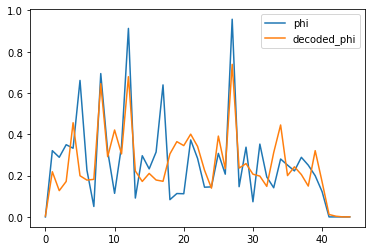

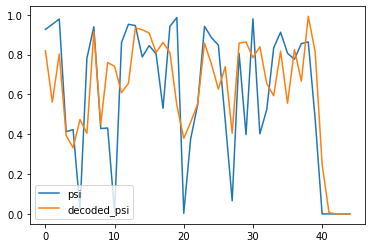

In [77]:
df_out.plot(y=(['AA','decoded_AA']),yticks=[i/20 for i in range(20)], grid=True)
df_out.plot(y=(['phi','decoded_phi']))
df_out.plot(y=(['psi','decoded_psi']))

# TSNE

PCA Shape:  (1091, 2)


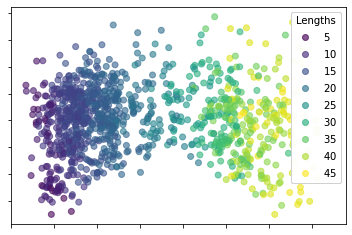

In [37]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

with torch.no_grad():
        batch_X = pre_train_X[:] #grab the batch
        batch_X = batch_X.float()
        batch_X = batch_X.to(device)
        recon_batch, mu, logvar = model(batch_X)

#First PCA reduce dims to 30
flattened_batch = batch_X[:].view(batch_X.size(0),-1) #flatten 3 channels to 1 (44*3)
pca = PCA(n_components=2)
pca_batch = pca.fit_transform(X=mu)
print("PCA Shape: ",pca_batch.shape)

#figuring out the length of the AMPs (to color code them by length)
all_lengths= []
for i in range(len(idx)):
    all_lengths.append(endpts['lengths'][ int(torch.IntTensor.item(idx[i])) ]) #gets all lengths. only need training lengths
lengths = all_lengths[:len(pre_train_X)]


#PLOT PCA FIRST
# Create scatterplot of dataframe
figure, bx = plt.subplots()
scatter = bx.scatter(pca_batch[:, 0], pca_batch[:, 1], c=lengths, cmap="viridis", alpha=0.6 )
legend1 = bx.legend(*scatter.legend_elements(num=10), loc="best", title="Lengths")
bx.add_artist(legend1)
bx.plot()
bx.xaxis.set_major_formatter(NullFormatter())
bx.yaxis.set_major_formatter(NullFormatter())

# #DO TSNE from PCA scan over 5 perplexities #uncomment for TSNE plots
# (fig, subplots) = plt.subplots(1, 5, figsize=(15, 8))
# ax = subplots[0]
# y_values = torch.round(flattened_batch[:,0]*22)
# ax.scatter(flattened_batch[:, 0], y_values, c="r")
# #ax.xaxis.set_major_formatter(NullFormatter())
# #ax.yaxis.set_major_formatter(NullFormatter())
# plt.axis('tight')

# perplexities = [5, 30, 50, 100]
# for i, perplexity in enumerate(perplexities):
#     tsne = TSNE(n_components=2, perplexity = perplexity, learning_rate = 500, n_iter=2000 )
#     tsne_fit = tsne.fit_transform(pca_batch)
#     print("T-SNE Shape: ", tsne_fit.shape)
#     print("Plotting t-SNE visualization...")
#     ax = subplots[i + 1]
#     ax.set_title("Perplexity=%d" % perplexity)
#     ax.scatter(tsne_fit[:,0], tsne_fit[:,1], c=tsne_fit[:,0])
#     legend1 = ax.legend(*scatter.legend_elements(num=10), loc="best", title="Lengths")
#     ax.add_artist(legend1)
#     ax.xaxis.set_major_formatter(NullFormatter())
#     ax.yaxis.set_major_formatter(NullFormatter())
#     ax.axis('tight')



# POST PROCESSING A SAMPLE

In [24]:
decoded_df = df_out.drop(['AA','phi','psi'], axis=1)
og_AA = df_out.drop(['decoded_AA','phi','psi','decoded_phi','decoded_psi'], axis=1)
phi = df_out.reindex(['phi'], axis=1)
psi = df_out.reindex(['psi'], axis=1)

AA = decoded_df.drop(['decoded_phi','decoded_psi'], axis=1)

phi_decoded = decoded_df.drop(['decoded_AA','decoded_psi'], axis=1)
psi_decoded = decoded_df.drop(['decoded_AA','decoded_phi'], axis=1)

In [25]:
import numpy as np

possible_AA= ['ala','arg','asn','asp','cys','glu','gln','gly','his','ile','leu','lys','met','phe','pro','ser','thr','trp','tyr','val','na']
non_norm_AA = np.round(AA*20)
non_norm_og_AA = np.round(og_AA*20)

categ_AA=[]
og_categ_AA=[]
for i in non_norm_AA.values:
    categ_AA.append(possible_AA[np.int(i)-1])
for i in non_norm_og_AA.values:
    og_categ_AA.append(possible_AA[np.int(i)-1])
compared=pd.DataFrame(og_categ_AA)

#in order to re-scale the angles properly we need to use the inverse of the original scaling so we redo the scaling here
from sklearn import preprocessing
import math

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaler.fit(np.reshape([-np.pi,np.pi],(-1,1))) #this makes sure to scale data using min -pi and max +pi

big_phi_dec = scaler.inverse_transform(phi_decoded)
big_psi_dec = scaler.inverse_transform(psi_decoded)

phi_dec_df = pd.DataFrame(big_phi_dec*180/np.pi) #going back to degrees from radians for use in pymol script
psi_dec_df = pd.DataFrame(big_psi_dec*180/np.pi)


big_phi = scaler.inverse_transform(phi)
big_psi = scaler.inverse_transform(psi)

phi_df = pd.DataFrame(big_phi*180/np.pi) #going back to degrees from radians for use in pymol script
psi_df = pd.DataFrame(big_psi*180/np.pi)

In [26]:
new_pd = pd.concat([compared,phi_df,psi_df,pd.DataFrame(categ_AA), phi_dec_df, psi_dec_df], axis=1)
new_pd.columns= ["Original_input","phi","psi","Training_AA","phi_dec","psi_dec"]

to_save_og = new_pd.drop(["Training_AA","phi_dec","psi_dec"], axis=1)
to_save_og = to_save_og[to_save_og.Original_input != 'na']

to_save_decoded = new_pd.drop(['Original_input',"phi","psi"], axis=1)
to_save_decoded = to_save_decoded[:len(to_save_og)]

In [27]:
to_save_og.to_csv("seq_phi_psi_og.csv",header=None, index=None, sep=' ', mode='w')
to_save_decoded.to_csv("seq_phi_psi_dec.csv",header=None, index=None, sep=' ', mode='w')

In [28]:
#import pymol and scripts:  http://pldserver1.biochem.queensu.ca/~rlc/work/pymol/
import pymol
pymol.cmd.run("seq_convert.py")
pymol.cmd.run("build_seq.py")
pymol.cmd.run("build_seq_phi_psi.py")

In [29]:
pymol.cmd.delete("all")

 PyMOL not running, entering library mode (experimental)


In [30]:
pymol.build_seq_phi_psi("seq_phi_psi_dec.csv")
pymol.cmd.set_name(old_name=str(to_save_decoded.loc[0][0]), new_name="amp_one") #need to change name to differentiate both in Pymol
pymol.cmd.delete("pk1")
pymol.build_seq_phi_psi("seq_phi_psi_og.csv")
pymol.cmd.set_name(old_name=pymol.cmd.get_names()[1], new_name="amp_two")

Number of amino acid/phi/psi values read:  41
Building sequence:  GIIRPPVPCMPWQHPCQNSDNHQFRIQQLDQKFKIDCCNRM
gly -179.51254 104.08302
ile -75.963234 118.203514
ile -134.7308 153.25067
arg -143.5798 44.12588
pro -129.4904 133.62674
pro -57.578262 -41.387802
val -77.80138 -52.36838
pro -47.613792 -28.926947
cys -65.805756 -46.42705
met -65.56779 -41.399082
pro -89.43484 -43.762024
trp -37.406353 -3.1681716
gln 112.85253 64.75973
his -118.12762 -126.473465
pro -130.21382 168.16379
cys -113.55899 149.37035
gln -125.514046 153.5639
asn -80.87467 -57.56708
ser -147.3534 159.22601
asp -111.489136 149.18013
asn -96.14007 160.86041
his -75.897194 163.8185
gln 114.51208 -24.92255
phe -124.927 162.86223
arg -129.14783 159.2648
ile -89.17158 97.5242
gln -80.85901 -11.671987
gln 173.67773 -148.25319
leu -105.771835 148.8852
asp -85.39664 74.16096
gln 80.65704 -52.820633
lys -58.0885 111.489456
phe -77.663 149.32234
lys 80.800156 -14.135756
ile -90.094864 123.65485
asp -102.59694 169.87044
cys -89.00

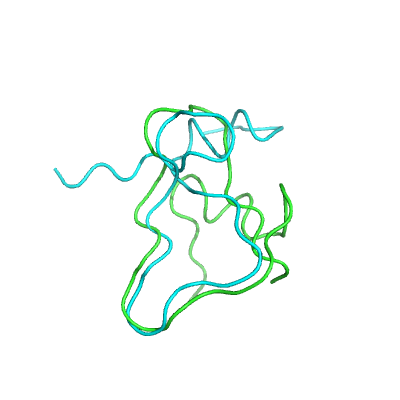

In [31]:
#adjust visuals
pymol.cmd.show_as('cartoon')
pymol.cmd.super(mobile="amp_one", target="amp_two")
pymol.cmd.zoom(complete=0)
pymol.cmd.reset()

#(string filename, int width=0, int height=0, float dpi=-1, int ray=0, int quiet=0)
pymol.cmd.png('C:\\Users\\samue\\Downloads\\research_project\\VAE\\foo.png', width=400,height=400,dpi=300,ray=1)
from IPython.display import Image
Image(filename='C:\\Users\\samue\\Downloads\\research_project\\VAE\\foo.png')

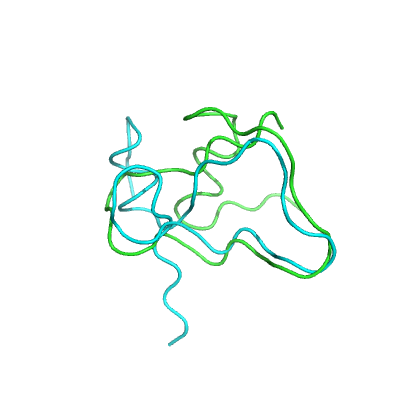

In [32]:
pymol.cmd.rotate(axis="z", angle=90)
pymol.cmd.png('C:\\Users\\samue\\Downloads\\research_project\\VAE\\foo.png', width=400,height=400,dpi=300,ray=1)
from IPython.display import Image
Image(filename='C:\\Users\\samue\\Downloads\\research_project\\VAE\\foo.png')